In [1]:
import sys
import os
import math
import numpy as np
import matplotlib
import cv2
import skimage
import keras
%matplotlib inline
print('Keras: {}'.format(keras.__version__))

Using TensorFlow backend.


Keras: 2.3.1


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Input
from keras.optimizers import Adam, SGD
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt

In [3]:
!git clone https://github.com/niazwazir/Set5_Images.git

Cloning into 'Set5_Images'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 59 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [4]:
!ls

sample_data  Set5_Images


In [5]:
cd Set5_Images

/content/Set5_Images


In [6]:
!ls

SET5_BMP.zip


In [7]:
!unzip SET5_BMP.zip

Archive:  SET5_BMP.zip
  inflating: SET5_BMP/baboon.bmp     
  inflating: SET5_BMP/baby_GT.bmp    
  inflating: SET5_BMP/barbara.bmp    
  inflating: SET5_BMP/bird_GT.bmp    
  inflating: SET5_BMP/butterfly_GT.bmp  
  inflating: SET5_BMP/coastguard.bmp  
  inflating: SET5_BMP/comic.bmp      
  inflating: SET5_BMP/face.bmp       
  inflating: SET5_BMP/flowers.bmp    
  inflating: SET5_BMP/foreman.bmp    
  inflating: SET5_BMP/head_GT.bmp    
  inflating: SET5_BMP/lenna.bmp      
  inflating: SET5_BMP/monarch.bmp    
  inflating: SET5_BMP/pepper.bmp     
  inflating: SET5_BMP/ppt3.bmp       
  inflating: SET5_BMP/woman_GT.bmp   
  inflating: SET5_BMP/zebra.bmp      


In [0]:
#define fumctions for image quality metrices

# Mean squared error(MSE)
def MSE(target, ref):
    
    error = np.sum((target.astype('float') - ref.astype('float')) **2)
    error /= float(target.shape[0] * target.shape[1])
    
    return error

#Peak-Signal-To-Noise-Ratio
def PSNR(target, ref):
    
    #assume RGB/BGR image
    target_data=target.astype(float)
    ref_data=ref.astype(float)
    
    diff=ref_data - target_data
    diff=diff.flatten('C')
    
    rmse=math.sqrt(np.mean(diff ** 2))
    
    return 20 * math.log10(255. / rmse)

#function to combine all three image quality metrices
def Compare_Images(target, ref):
    scores=[]
    scores.append(PSNR(target, ref))
    scores.append(MSE(target, ref))
    scores.append(ssim(target, ref, multichannel= True))
    
    return scores
    

In [0]:
#prepare degraded images by intruducing quality distortion
def Prepare_Images(path, factor):
    for file in os.listdir(path):
        
        img=cv2.imread(path + '/' + file )
        
        #old dimensions
        h,w,c=img.shape
        
        #new diemnsions
        new_height= int(h / factor)
        new_width= int(w / factor)
        
        #resize the images - down
        img = cv2.resize(img, (new_width, new_height), interpolation= cv2.INTER_LINEAR)
        
        #resize the images - up
        img = cv2.resize(img, (w,h), interpolation= cv2.INTER_LINEAR)
        
        #save the images
        print('Saving{}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)
        

In [0]:
mkdir images

In [11]:
Prepare_Images('SET5_BMP/', 2)

Savingzebra.bmp
Savingwoman_GT.bmp
Savingflowers.bmp
Savingcoastguard.bmp
Savingbarbara.bmp
Savingforeman.bmp
Savingface.bmp
Savingbaboon.bmp
Savinghead_GT.bmp
Savinglenna.bmp
Savingbutterfly_GT.bmp
Savingppt3.bmp
Savingbaby_GT.bmp
Savingmonarch.bmp
Savingcomic.bmp
Savingpepper.bmp
Savingbird_GT.bmp


In [0]:
# SRCNN Model 
def model():
    
    SRCNN=Sequential()
    
    # add layers
    SRCNN.add(Conv2D(filters=128, kernel_size=(9,9), kernel_initializer='glorot_uniform',activation='relu',
                     input_shape=(None,None,1), padding='valid', use_bias=True))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='glorot_uniform',activation='relu',
                     padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform',activation='linear',
                     padding='valid', use_bias=True))
    
    #optimizer
    adam=Adam(lr=0.0003)
    
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

In [0]:
# necessary image preprocessing functions
def ModCrop(img, scale):
    temp_size=img.shape
    size=temp_size[0:2]
    
    #ensuring that dimension of our images are divisble by certain scale by subtracting the remainder from dimensions
    size=size -np.mod(size, scale)
    
    #size[0] and size[1] respectively defines the dimensions after scaling and say the dimension after scaling  is 256 *256 px
    # so  img[0:256,1:256] gives us all pixel information
    
    img= img[0:size[0], 1:size[1]]
    
    return img

 
# function to crop an image
def Crop(image, border):
    img=image[border:-border, border:-border]
    return img
    

In [14]:
!git clone https://github.com/niazwazir/SRCNN-Keras.git

Cloning into 'SRCNN-Keras'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 67 (delta 3), reused 0 (delta 0), pack-reused 55
Unpacking objects: 100% (67/67), done.


In [0]:
# Main prediction function

def predict(image_path):
    
    srcnn=model()
    srcnn.load_weights('SRCNN-Keras/3051crop_weight_200.h5')
    
    #load the degraded and refernce images
    path, file=os.path.split(image_path)
    degraded=cv2.imread(image_path)
    ref=cv2.imread('SET5_BMP/{}'.format(file))
    
    #preprocess the image or crop the image using modcrop
    degraded=ModCrop(degraded, 3)
    ref=ModCrop(ref,3)
    
    #convert the image to YCrCb as srcnn trained on Y channel
    temp=cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize
    Y=np.zeros((1,temp.shape[0],temp.shape[1],1), dtype=float)
    Y[0,:,:,0]=temp[:,:,0].astype(float) / 255
    
    # apply the model 
    pre=srcnn.predict(Y,batch_size=1)
    
    #post_process output
    pre *=255 #to get back the normal pixel values
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre=pre.astype(np.uint8)
    
    # copying y channel back to image and convert image to BGR
    temp=Crop(temp, 6) #by doing this the image will loose 3 pixels in both left and top and right-bottom
    temp[:, :, 0] = pre[0,:, :, 0]
    reconstructed_image=cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    #remove border from degraded and reference images
    degraded=Crop(degraded.astype(np.uint8), 6)
    ref=Crop(ref.astype(np.uint8), 6)
    
    #image quality calculations
    scores=[]
    scores.append(Compare_Images(degraded, ref))
    scores.append(Compare_Images(reconstructed_image, ref))
    
    #return images and scores
    return ref, degraded, reconstructed_image, scores
    
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image:
PSNR: 25.888852808173493 
MSE: 502.7086229899586
SSIM: 0.8086912237988951

Reconstructed Image:
PSNR: 26.575779039435897 
MSE: 429.1644221413023
SSIM: 0.8550465844171153



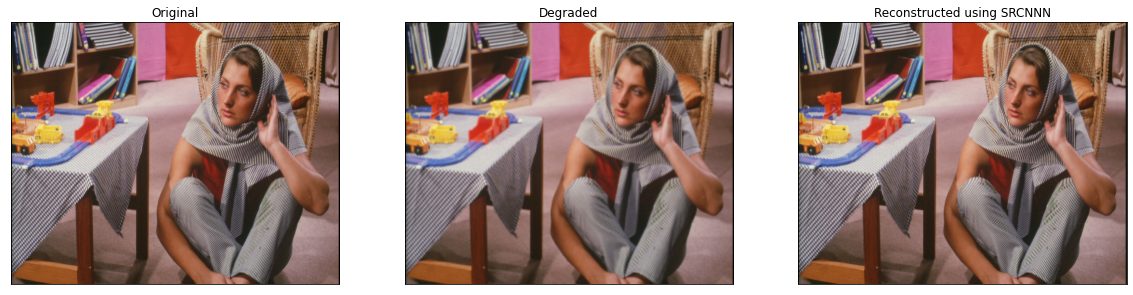

In [16]:
ref, degraded, reconstructed_image, scores= predict('images/barbara.bmp')
#print scores
print("Degraded Image:\nPSNR: {} \nMSE: {}\nSSIM: {}\n".format(scores[0][0],scores[0][1],scores[0][2]))
print("Reconstructed Image:\nPSNR: {} \nMSE: {}\nSSIM: {}\n".format(scores[1][0],scores[1][1],scores[1][2]))

#display images as subplot
fig, axes=plt.subplots(1,3, figsize=(20, 10))
axes[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)) #we convert the image from BGR to RGB as "imshow" wants the image as RGB format
axes[0].set_title('Original')
axes[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axes[1].set_title('Degraded')
axes[2].imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
axes[2].set_title('Reconstructed using SRCNNN')

#remove x and y axis tick marks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
